In [1]:
import pandas as pd
import numpy as np
import os
#import torch
from recbole.utils.case_study import full_sort_topk, full_sort_scores
from recbole.quick_start import load_data_and_model
from recbole.data.interaction import Interaction

#viz
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go 
from joypy import joyplot
import sys  
import gc

gc.collect()
  
sys.setrecursionlimit(9000)  # original it's 3000
rootpath="../../Datasets/GoodReads/"
image_path = './Figure/'
image_name_pref = 'GoodReads'

In [46]:
# essential functions
CAT_COL = 'genre'
ITEM_COL = 'item_id'
df10 = pd.read_csv('../Data/GoodReads/df_2010.csv')
item_categories = df10[['item_id','genre']].drop_duplicates()


class Item:
    """
    Data holder for our item.
    
    Parameters
    ----------
    id : int

    cat : dict[str, float]
        The item/movie's genre distribution, where the key
        represents the genre and value corresponds to the
        ratio of that genre.

    score : float
        Score for the item, potentially generated by some
        recommendation algorithm.
    """
    def __init__(self, _id, cats):
        self.id = _id
        self.cats = cats

    def __repr__(self):
        return f"{self.id}: {self.cats}"


def create_item_mapping(df_item, item_col, cat_col):
    """Create a dictionary of item id to Item lookup."""
    item_mapping = {}
    for row in df_item.itertuples():
        item_id = getattr(row, item_col)
        item_cat = getattr(row, cat_col)
        
        item_cat_temp = item_cat.split('-')
        cat_ratio = 1. / len(item_cat_temp)
        item_cat = {cat: cat_ratio for cat in item_cat_temp}

        item = Item(item_id, item_cat)
        item_mapping[item_id] = item

    return item_mapping

item_cat_mapping = create_item_mapping(item_categories, ITEM_COL, CAT_COL)
item_cat_mapping[1]

def compute_cats_distr(items, item_cat_mapping):
    """Compute the genre distribution for a given list of items."""
    distr = {}
    for item in items:
        for cat, score in item_cat_mapping[item].cats.items():
            cat_score = distr.get(cat, 0.)
            distr[cat] = cat_score + score

    # we normalize the summed up probability so it sums up to 1
    # and round it to three decimal places, adding more precision
    # doesn't add much value and clutters the output
    for cat, cat_score in distr.items():
        normed_cat_score = cat_score / len(items)
        distr[cat] = normed_cat_score

    return distr

def compute_kl_divergence(interacted_distr, reco_distr, alpha=0.01):
    """
    KL (p || q), the lower the better.

    alpha is not really a tuning parameter, it's just there to make the
    computation more numerically stable.
    """
    kl_div = 0.
    for genre, score in interacted_distr.items():
        reco_score = reco_distr.get(genre, 0.)
        reco_score = (1 - alpha) * reco_score + alpha * score
        kl_div += score * np.log2(score / reco_score)

    return kl_div

def metric_calibration(ratings_s, ratings_r, users_id, item_id=ITEM_COL, item_cat_mapping=item_cat_mapping): 
    '''calculate the calibration metric
    interacted_items: input historical ratings
    reco_items: output recommendation list
    item_cat_mapping: Compute the genre distribution for a given list of Items.'''
    
    output_dict = dict()
    inter_users_id = ratings_s.user_id.unique().tolist()
    
    if len(users_id)==len(inter_users_id):
        print('users in inter and rec: consistent')
    else: 
        print('users in inter and rec: inconsistent')
    
    for user_g_id, recommended_ls in zip(users_id,ratings_r):
        #print('user_id', user_g_id)
        interact_df = ratings_s[ratings_s.user_id == user_g_id]
        #interact_ls = interact_df.item_id.unique().tolist()
        interact_ls = interact_df[item_id].tolist()
        
        interact_dist = compute_cats_distr(interact_ls, item_cat_mapping)

        recommended_ls = list(map(int, recommended_ls))
        recommended_dist = compute_cats_distr(recommended_ls, item_cat_mapping)

        user_g_cm = compute_kl_divergence(interact_dist, recommended_dist)
        output_dict[user_g_id] = user_g_cm

    output_df = pd.DataFrame.from_dict(output_dict, orient='index')
     
    #output_df = output_df.reset_index()
    #output_df = output_df.rename(columns={"index": "user_id"})

    return output_dict, output_df


import numpy as np
import torch

from recbole.data.interaction import Interaction


@torch.no_grad()
def full_sort_scores_mod(uid_series, model, test_data, device=None):
    """Calculate the scores of all items for each user in uid_series.

    Note:
        The score of [pad] and history items will be set into -inf.

    Args:
        uid_series (numpy.ndarray or list): User id series.
        model (AbstractRecommender): Model to predict.
        test_data (FullSortEvalDataLoader): The test_data of model.
        device (torch.device, optional): The device which model will run on. Defaults to ``None``.
            Note: ``device=None`` is equivalent to ``device=torch.device('cpu')``.

    Returns:
        torch.Tensor: the scores of all items for each user in uid_series.
    """
    device = device or torch.device("cpu")
    uid_series = torch.tensor(uid_series)
    uid_field = test_data.dataset.uid_field
    dataset = test_data.dataset
    model.eval()

    if not test_data.is_sequential:
        input_interaction = dataset.join(Interaction({uid_field: uid_series}))
        history_item = test_data.uid2history_item[list(uid_series)]
        ######### mod begin ########
        print(f"Before mod: {len(uid_series)} and {len(history_item)}")
        history_item,uid_series = zip(*((x,y) for x,y in zip(history_item,uid_series) if type(x) != type(None)))
        print(f"After mod: {len(uid_series)} and {len(history_item)}")
        ########## mod end ########
        history_row = torch.cat(
            [torch.full_like(hist_iid, i) for i, hist_iid in enumerate(history_item)]
        )
        history_col = torch.cat(list(history_item))
        history_index = history_row, history_col
    else:
        _, index = (dataset.inter_feat[uid_field] == uid_series[:, None]).nonzero(
            as_tuple=True
        )
        input_interaction = dataset[index]
        history_index = None

    # Get scores of all items
    input_interaction = input_interaction.to(device)
    try:
        scores = model.full_sort_predict(input_interaction)
    except NotImplementedError:
        input_interaction = input_interaction.repeat_interleave(dataset.item_num)
        input_interaction.update(
            test_data.dataset.get_item_feature().to(device).repeat(len(uid_series))
        )
        scores = model.predict(input_interaction)

    scores = scores.view(-1, dataset.item_num)
    scores[:, 0] = -np.inf  # set scores of [pad] to -inf
    if history_index is not None:
        scores[history_index] = -np.inf  # set scores of history items to -inf

    return scores


def full_sort_topk_mod(uid_series, model, test_data, k, device=None):
    """Calculate the top-k items' scores and ids for each user in uid_series.

    Note:
        The score of [pad] and history items will be set into -inf.

    Args:
        uid_series (numpy.ndarray): User id series.
        model (AbstractRecommender): Model to predict.
        test_data (FullSortEvalDataLoader): The test_data of model.
        k (int): The top-k items.
        device (torch.device, optional): The device which model will run on. Defaults to ``None``.
            Note: ``device=None`` is equivalent to ``device=torch.device('cpu')``.

    Returns:
        tuple:
            - topk_scores (torch.Tensor): The scores of topk items.
            - topk_index (torch.Tensor): The index of topk items, which is also the internal ids of items.
    """
    scores = full_sort_scores_mod(uid_series, model, test_data, device)
    return torch.topk(scores, k)


In [47]:
def categories(row, t_list, col = 'activity_counts'):
    """t_list incl. [0, 33.33, 66.67, 100]"""
    if row[col]<=t_list[1]:
        return 1
    elif row[col]>t_list[1] and row[col]<=t_list[2]:
        return 2
    elif row[col]>t_list[2] and row[col]<=t_list[3]:
        return 3
    
# check the label distribution over the 0.5 Years 
# each user's profile entropy 

def compute_profile_entropy(items, item_cat_mapping):
    """Compute the genre distribution for a given list of items -- profile entropy."""
    return_value = 0
    profile_distr = compute_cats_distr(items, item_cat_mapping)
    profile_distr_sum = sum(profile_distr.values())
    
    for genre, score in profile_distr.items():
        if score != 0:
            score = score/profile_distr_sum
            return_value += score * np.log2(score)
    
    return -return_value

# Read in essential files

In [52]:
OUTPATH = './GoodReads/'
OUTNAME = 'GoodReads_HY'

ds_all_windows = {}
for i in range(1,17):
    temp = pd.read_csv(f"{OUTPATH}{OUTNAME}_{i}/{OUTNAME}_{i}.csv")
    ds_all_windows[i] = temp
    print(f'{i}: {temp.shape};\t unique users #: {len(temp.user_id.unique())};\t unique items #: {len(temp.item_id.unique())};\t \
    sparsity: {1-len(temp)/(len(temp.user_id.unique())*len(temp.item_id.unique())):.3f}')

1: (2857, 4);	 unique users #: 767;	 unique items #: 908;	     sparsity: 0.996
2: (8803, 4);	 unique users #: 865;	 unique items #: 1333;	     sparsity: 0.992
3: (15186, 4);	 unique users #: 865;	 unique items #: 1485;	     sparsity: 0.988
4: (22468, 4);	 unique users #: 865;	 unique items #: 1555;	     sparsity: 0.983
5: (29375, 4);	 unique users #: 865;	 unique items #: 1605;	     sparsity: 0.979
6: (36956, 4);	 unique users #: 865;	 unique items #: 1636;	     sparsity: 0.974
7: (44305, 4);	 unique users #: 865;	 unique items #: 1648;	     sparsity: 0.969
8: (52071, 4);	 unique users #: 865;	 unique items #: 1653;	     sparsity: 0.964
9: (59237, 4);	 unique users #: 865;	 unique items #: 1656;	     sparsity: 0.959
10: (67004, 4);	 unique users #: 865;	 unique items #: 1661;	     sparsity: 0.953
11: (73793, 4);	 unique users #: 865;	 unique items #: 1661;	     sparsity: 0.949
12: (81279, 4);	 unique users #: 865;	 unique items #: 1661;	     sparsity: 0.943
13: (88018, 4);	 unique user

In [53]:
#itemknn 
DF_SECD = pd.read_excel('./HyperTuning_GoodReads.xlsx',sheet_name='ItemKNN')
DF_SECD['DataIndex'] = DF_SECD['hy']
DF_SECD.head(1)

hy    k  shrink  recall_10  ndcg_10  DataIndex
0   1  100     0.5     0.0917   0.0564          1

In [54]:
# activity degree
activity_all_windows = {i:ds.groupby('user_id').size().reset_index(name='activity_counts')
                       for i, ds in ds_all_windows.items()}

In [ ]:
#read in experiment results (ItemKNN)

import os
from recbole.utils.case_study import full_sort_topk, full_sort_scores
from recbole.quick_start import load_data_and_model

MODEL_LOC_ROOT = './GoodReads'
MODEL_NAME = 'ItemKNN'
DATASET_NAME = 'GoodReads_HY'
DATASET_LOC = '../Data/GoodReads'
DATASETS = {int(f.split('_')[-1]):f for f in os.listdir(DATASET_LOC) if f.startswith(DATASET_NAME)}
USER_COL = 'user_id'

calibration_comparison_1D_multi = {}

DATA_INDEX_max = max(DATASETS.keys())

# activity degree already available: activity_all_windows[DATA_INDEX]
temp_activity = activity_all_windows[DATA_INDEX_max]
percentiles_list = [np.percentile(temp_activity[['activity_counts']], _p) 
                    for _p in [0, 33.33, 66.67, 100]]
temp_activity['user_group_activity'] = temp_activity.apply(lambda row: categories(row, percentiles_list, 
                                                                                  'activity_counts'), 
                                                           axis=1)

# calculate entropy
DATASET = DATASETS[DATA_INDEX_max]
interact_dataset = pd.read_csv(f"{DATASET_LOC}/{DATASET}/{DATASET}.csv")
USER_IDS = interact_dataset[USER_COL].unique()
user_profile_entropy_dict = {_user:compute_profile_entropy(interact_dataset[interact_dataset[USER_COL]==_user][ITEM_COL].tolist(), 
                                                           item_cat_mapping) for _user in USER_IDS}
temp_entropy = pd.DataFrame.from_dict(user_profile_entropy_dict, orient='index', columns=['profile_entropy'])
temp_entropy.reset_index(names=[USER_COL],inplace=True)
percentiles_list = [np.percentile(temp_entropy[['profile_entropy']], _p) 
                    for _p in [0, 33.33, 66.67, 100]]
temp_entropy['user_group_entropy'] = temp_entropy.apply(lambda row: categories(row, percentiles_list, 
                                                                                'profile_entropy'), 
                                                        axis=1)
# all related side info 
temp = temp_activity.merge(temp_entropy, on=USER_COL)


for DATA_INDEX,DATASET in DATASETS.items():
    calibration_comparison_1D_multi[DATA_INDEX] = dict()
    interact_dataset = pd.read_csv(f"{DATASET_LOC}/{DATASET}/{DATASET}.csv")
    USER_IDS_STR = list(map(str, interact_dataset.user_id.unique())) #1409 users in total
    USER_IDS = interact_dataset[USER_COL].unique()
    #print(f"User amount from DatasetIndex {DATA_INDEX}: {len(USER_IDS)}")

    
    models = [_m for _m in os.listdir(f"{MODEL_LOC_ROOT}/{DATASET}") if _m.endswith('.pth') and _m.startswith(MODEL_NAME)]
    for model_file in models: 
        config, model, dataset, train_data, valid_data, test_data = load_data_and_model(
            model_file=f"{MODEL_LOC_ROOT}/{DATASET}/{model_file}",
        )
        uid_series = dataset.token2id(dataset.uid_field, USER_IDS_STR)
        topk_score, topk_iid_list = full_sort_topk_mod(
            uid_series, model, test_data, k=10, device=config["device"]
        )
        external_item_list = dataset.id2token(dataset.iid_field, topk_iid_list.cpu())
    
        ca_dict, ca_df = metric_calibration(interact_dataset, external_item_list, USER_IDS)
        ca_df['DataIndex'] = DATA_INDEX
        ca_df['ModelFile'] = model_file.split('.')[0]
        ca_df.reset_index(names=[USER_COL],inplace=True)
        ca_df.rename(columns={0:'miscalibration'},inplace=True)
        all_df = ca_df.merge(temp, on=USER_COL)
        calibration_comparison_1D_multi[DATA_INDEX][model_file.split('.')[0]] = all_df


In [59]:
import pickle
with open('goodreads_calibration_comparison_1D_multi_knn.pickle', 'wb') as handle:
    pickle.dump(calibration_comparison_1D_multi, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('goodreads_calibration_comparison_1D_multi_knn.pickle', 'rb') as handle:
#    calibration_comparison_1D_multi = pickle.load(handle)

In [60]:
agg_inside_1d_df = {k:pd.concat(list(dfs.values())) for k, dfs in calibration_comparison_1D_multi.items()}
agg_across_1d_df = pd.concat(list(agg_inside_1d_df.values()))
agg_across_1d_df.sort_values(['DataIndex', 'ModelFile'], inplace=True)
agg_across_1d_df.head()

user_id  miscalibration  DataIndex  \
0  00da0024bf1c2340ba478bbf9c135d68        1.552016          1   
1  00ea9b2b113b8820b6aa7d64eadac428        3.350412          1   
2  027be0744c9b6fbf81f365bc42e29507        0.169807          1   
3  0351df2c91022c8c020fdedd210456d6        1.703689          1   
4  037c382333b7084ccee4cdec7401de90        0.664186          1   

                      ModelFile  activity_counts  user_group_activity  \
0  ItemKNN-Apr-18-2024_08-40-43              182                    3   
1  ItemKNN-Apr-18-2024_08-40-43              111                    2   
2  ItemKNN-Apr-18-2024_08-40-43               58                    1   
3  ItemKNN-Apr-18-2024_08-40-43               67                    1   
4  ItemKNN-Apr-18-2024_08-40-43              105                    2   

   profile_entropy  user_group_entropy  
0         1.829007                   2  
1         1.699433                   1  
2         1.317659                   1  
3         1.766633                   1  
4         2.264292                   3

In [61]:
font_size = 15
marker_size = 3
line_size = 3
dtick_length = 1
legend_font_size = 15

# Part 0: Some viz for whole population

In [62]:
DF = agg_across_1d_df
CAT_COL = 'DataIndex'
TARGET_COL = 'miscalibration'
DF_MEAN = DF[[CAT_COL,TARGET_COL]].groupby(CAT_COL, as_index=False).mean().melt(id_vars=CAT_COL)

CAT_COL_SECD = 'DataIndex'
TARGET_COL_SECD = 'ndcg_10'



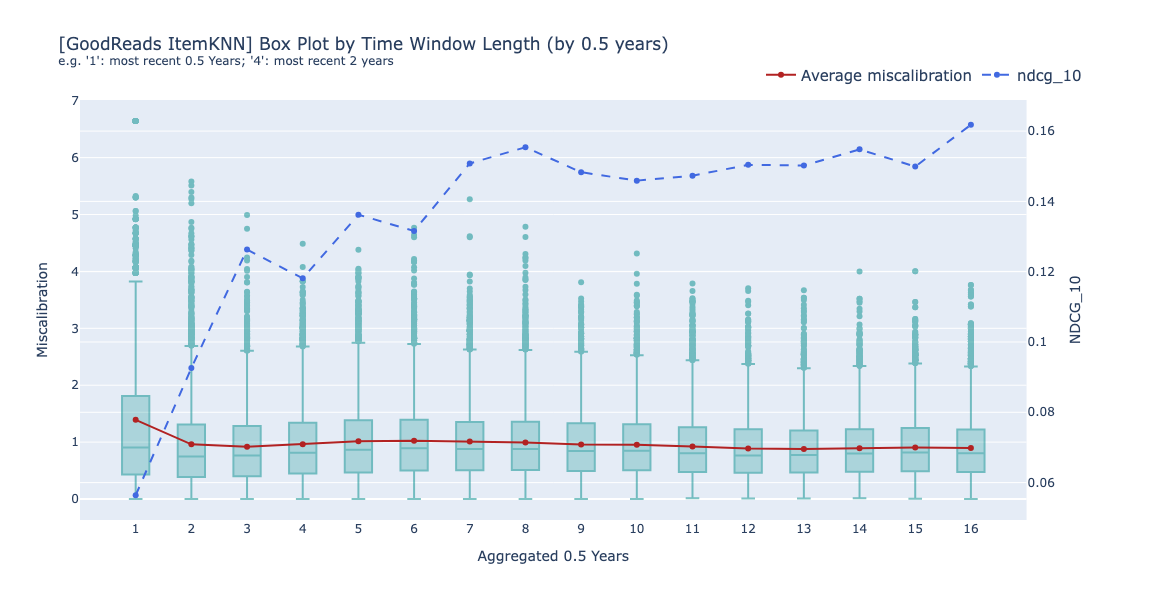

In [68]:
text = "[GoodReads ItemKNN] Box Plot by Time Window Length (by 0.5 years) <br><sup>e.g. '1': most recent 0.5 Years; '4': most recent 2 years</sup>"
cat_order = sorted(DF.DataIndex.unique())
#c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, len(cat_order))]#
#c = ['hsl(120'+',50%'+',50%)' for h in np.linspace(0, 360, len(cat_order))]
c = ['darkcyan' for  h in np.linspace(0, 360, len(cat_order))]
fig = make_subplots(specs=[[{"secondary_y": True}]])                                             

for _i,_c in zip(cat_order,c):
    fig.add_trace(go.Box(
        y = DF[DF[CAT_COL]==_i][TARGET_COL],
        opacity=0.5,
        name = str(_i),
        marker_color=_c, showlegend=False
    ), secondary_y=False)

trace_mean = go.Scatter(
    x=DF_MEAN[CAT_COL],
    y=DF_MEAN['value'],
    name='Average miscalibration',
    mode='lines+markers',
    line = dict(color='firebrick')
)
fig.add_trace(trace_mean, secondary_y=False)

trace_secd = go.Scatter(
    x = DF_SECD[CAT_COL_SECD],
    y = DF_SECD[TARGET_COL_SECD],
    name = TARGET_COL_SECD,
    mode='lines+markers',
    line=dict(color='royalblue',
             dash='dash')
)
fig.add_trace(trace_secd, secondary_y=True)

fig.update_layout(
    height=600, width=1300, 
    title_text=text,
    xaxis_title='Aggregated 0.5 Years',
    yaxis_title='Miscalibration',
    yaxis2_title='NDCG_10',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(
            size=legend_font_size,
        )),
    xaxis = dict(
        tickmode = 'linear',
        dtick = dtick_length,
        range=[-1,16]
    ),
)
iplot(fig)

image_name = 'FullMiscalibrationItemKNN'
fig.write_image(f"{image_path}{image_name_pref}_{image_name}.png")

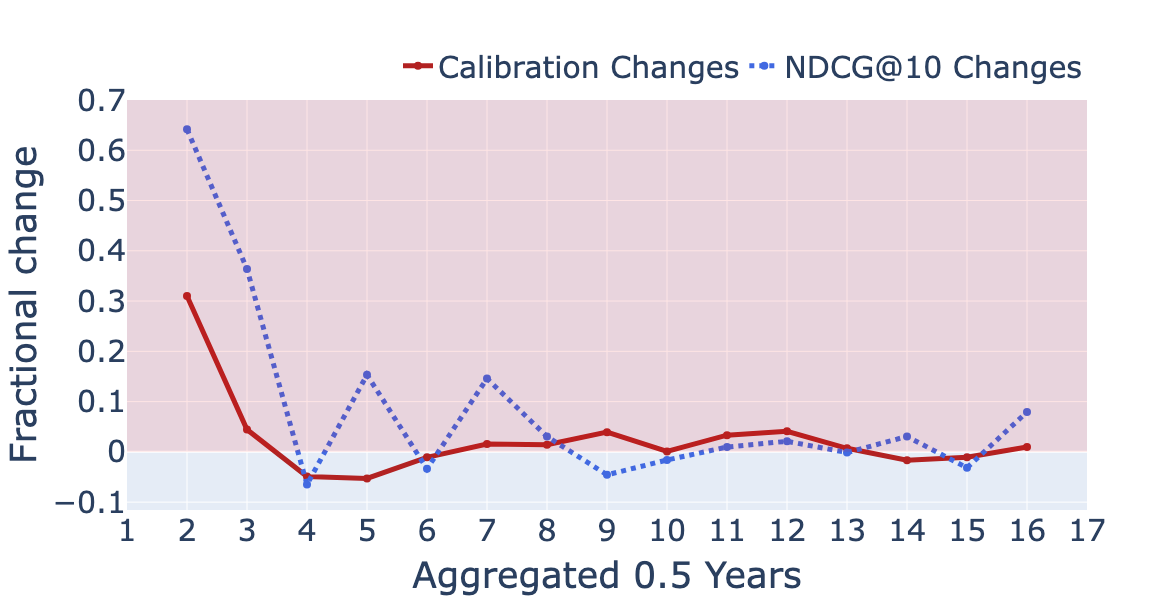

In [80]:
miscalibration_chg = DF_MEAN['value'].pct_change().tolist()[1:]
calibration_chg = [-v for v in miscalibration_chg]
ndcg_chg = DF_SECD['ndcg_10'].pct_change().tolist()[1:]

ys = [calibration_chg, ndcg_chg]
names = ['Calibration Changes', 'NDCG@10 Changes']
colors = ['firebrick','royalblue'] 
dashes = ['solid','dot']

fig = go.Figure()

fig.add_trace(go.Scatter(
    x = list(range(2,17)),
    y = ys[0],
    mode='lines+markers',
    name=names[0],
    
    marker = dict(
        size=8
    ),
    
    line = dict(
        color = colors[0],
        width=5,
        dash=dashes[0]
    )
))

fig.add_trace(go.Scatter(
    x = list(range(2,17)),
    y = ys[1],
    mode='lines+markers',
    name=names[1],
    
    marker = dict(
        size=8
    ),
    
    line = dict(
        color = colors[1],
        width=5,
        dash=dashes[1]
    )
))
fig.add_hrect(y0=0, y1=0.7, line_width=0, fillcolor="red", opacity=0.1)

fig.update_layout(
    height=600, width=1300, 
    #title=f'Miscalibration of user segments by different {GROUP_COL}', # Title
    #title=f'[GoodReads] Fractional change of claibration and ndcg@10 from previous to current window', # Title
    xaxis_title='Aggregated 0.5 Years', # y-axis name
    yaxis_title=f'Fractional change', # x-axis name
    #xaxis_tickangle=45,  # Set the x-axis label angle
    showlegend=True,     # Display the legend
    xaxis = dict(
        tickmode = 'linear',
        dtick =1,
        range=[1,17]
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(
            size=30,
        ),
    ),
    font=dict(size=30,)
)

iplot(fig)
image_name = 'FractionalChangeItemKNN'
fig.write_image(f"{image_path}{image_name_pref}_{image_name}.png", width=1400, height=700)

# Part 1: User Segment

    > via user activity degree
    > via user profile entropy

## 1.1 User activity degree and user entropy

    --> via three activity degree (high-mid-low)

### [a1] explore the degree threshold. 

    > check the distribution for each time window first. 
    > via proportion, evenly distributed? 
    
    **NOTE: based on the exploration, segment the users into 5 portions mainly via population proportion.**

In [7]:
for i, ds in activity_all_windows.items():
    print('\n',i)
    print(f'sum \t {ds.counts.sum()}')
    print(ds.counts.describe())


 1
sum 	 915
count    491.000000
mean       1.863544
std        1.603477
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       14.000000
Name: counts, dtype: float64

 2
sum 	 2939
count    1086.000000
mean        2.706262
std         2.350664
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        24.000000
Name: counts, dtype: float64

 3
sum 	 6620
count    1344.000000
mean        4.925595
std         3.759580
min         1.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        64.000000
Name: counts, dtype: float64

 4
sum 	 12094
count    1394.000000
mean        8.675753
std         5.664555
min         1.000000
25%         5.000000
50%         7.500000
75%        11.000000
max        64.000000
Name: counts, dtype: float64

 5
sum 	 21031
count    1407.000000
mean       14.947406
std         7.735681
min         1.000000
25%        10.000000
50%        14.000000
75%        19.0000

In [24]:
temp_ds = pd.DataFrame(columns=['user_id','counts','timewindow'])
temp_ds = temp_ds.astype({"user_id": int, "counts": int, "timewindow": int})
for i, ds in activity_all_windows.items():
    ds['timewindow'] = i
    temp_ds = pd.concat([temp_ds, ds])
temp_ds.head(2)

user_id  counts  timewindow
0       19       2           1
1       24       2           1

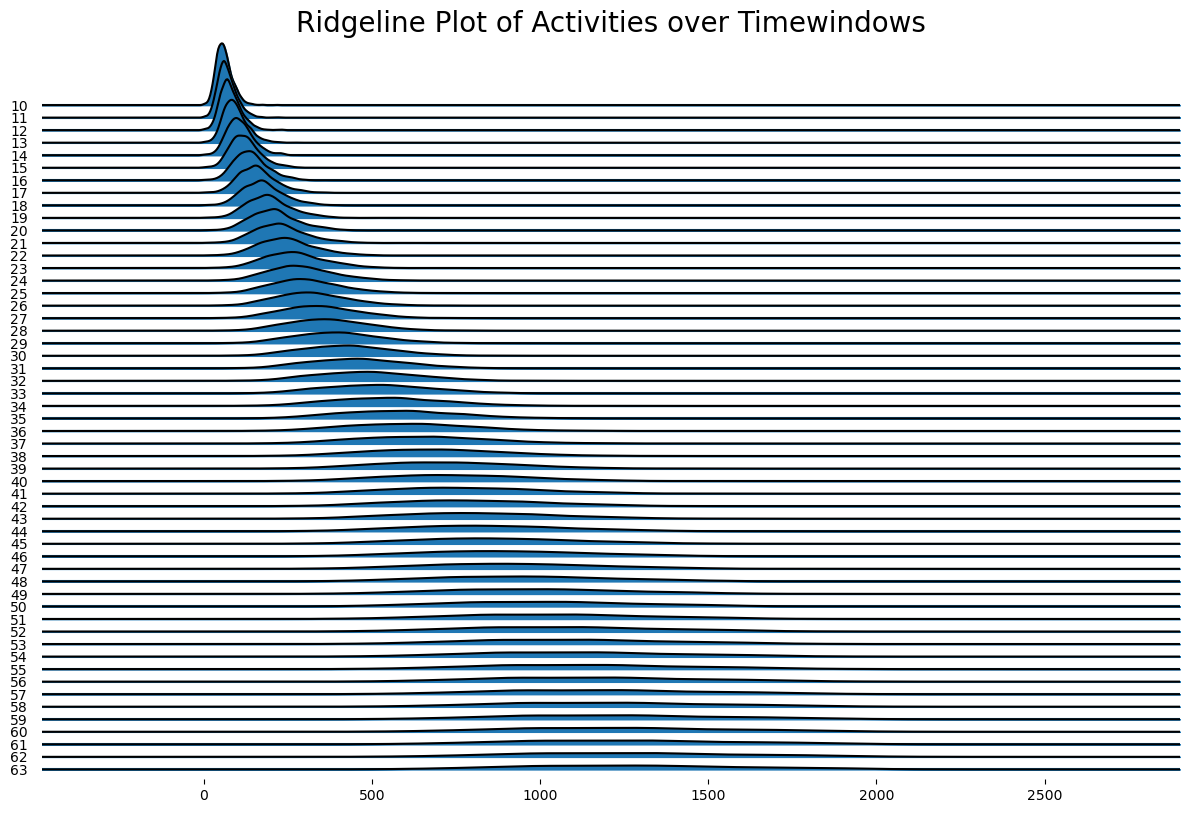

In [48]:
joyplot(
    data=temp_ds[(temp_ds.timewindow>=10)][['counts', 'timewindow']], 
    by='timewindow',
    figsize=(12, 8)
)
plt.title('Ridgeline Plot of Activities over Timewindows', fontsize=20)
plt.show()

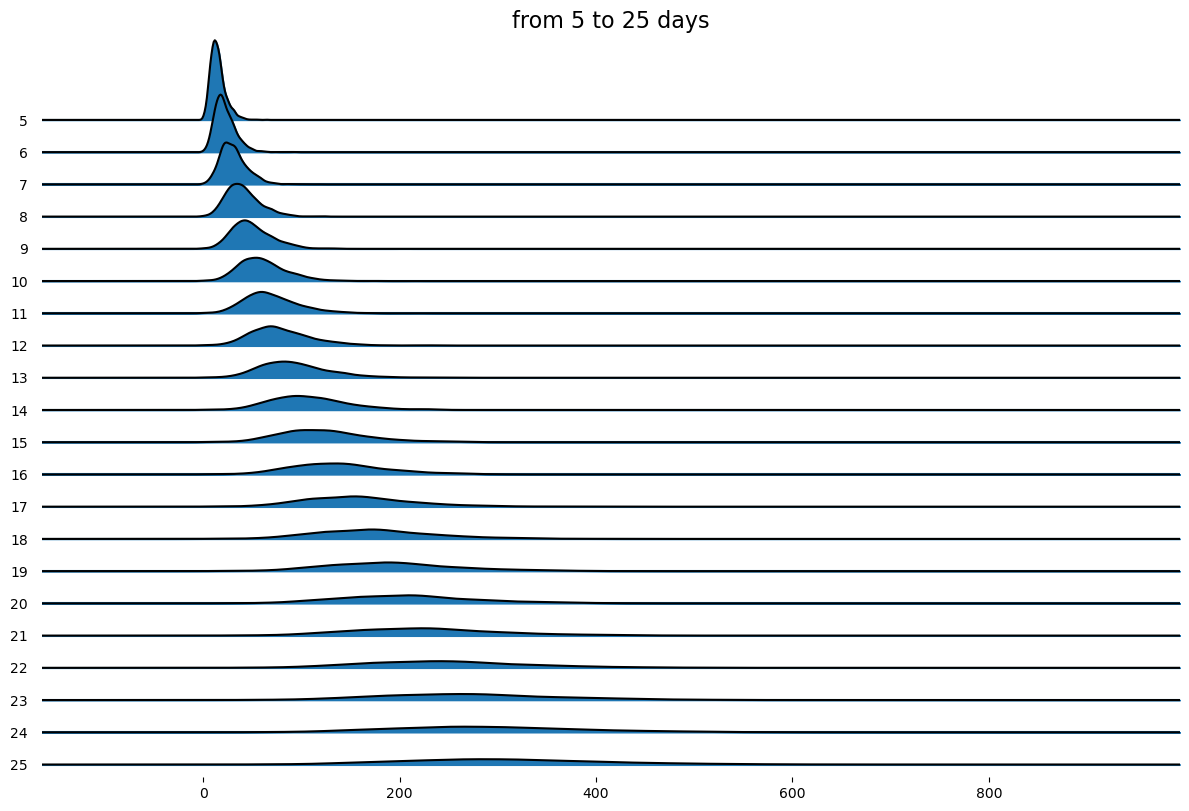

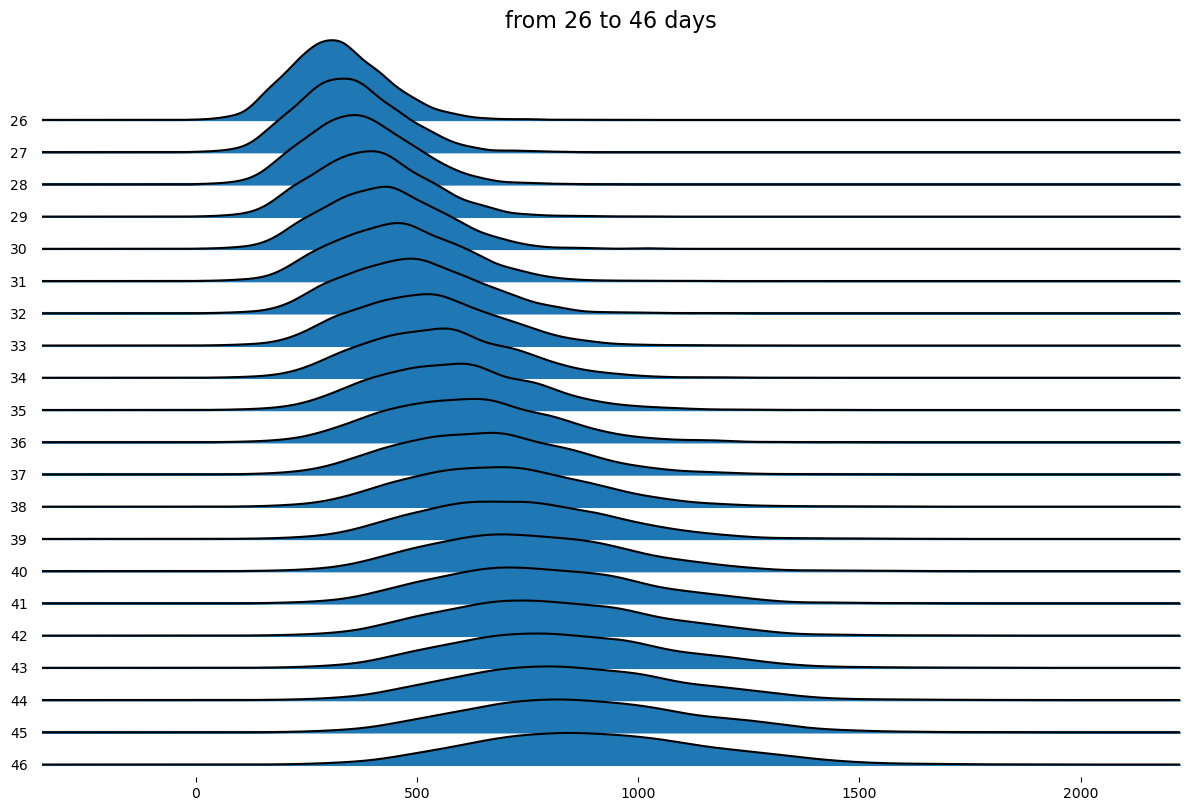

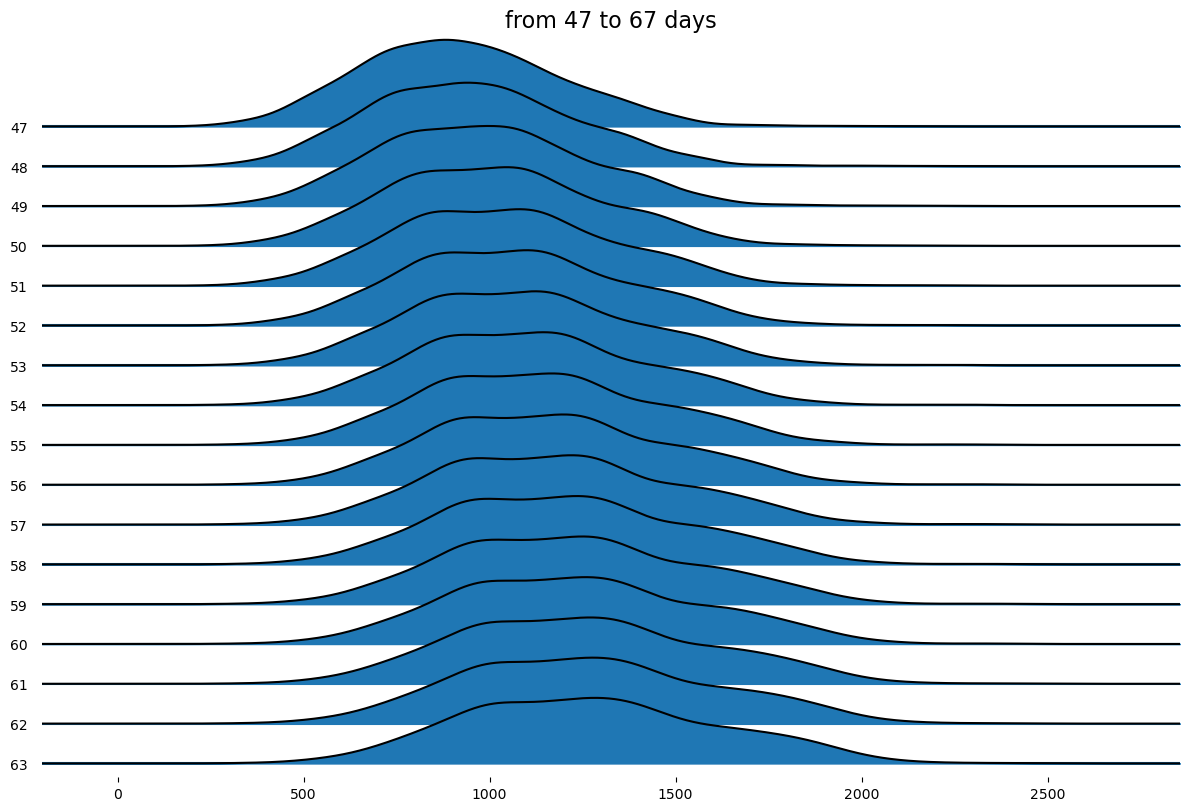

In [52]:
for i in range(5, 64, 21): 
    tt = temp_ds[(temp_ds.timewindow<i+21) & (temp_ds.timewindow>=i)]
    joyplot(
        data=tt[['counts', 'timewindow']], 
        by='timewindow',
        figsize=(12, 8)
    )
    plt.title(f'from {i} to {i+20} 0.5 Years', fontsize=16)
    plt.show()

    NOTE:
    
    > segment into 3 groups by the population portion

### [c1] viz of activity degree 


    refined definition based on the feedbacks -- based on the overall histroy, not for each given time windows. 

    > based on user's full history
    > based on user's activity per active day

#### [c1] activity by full history

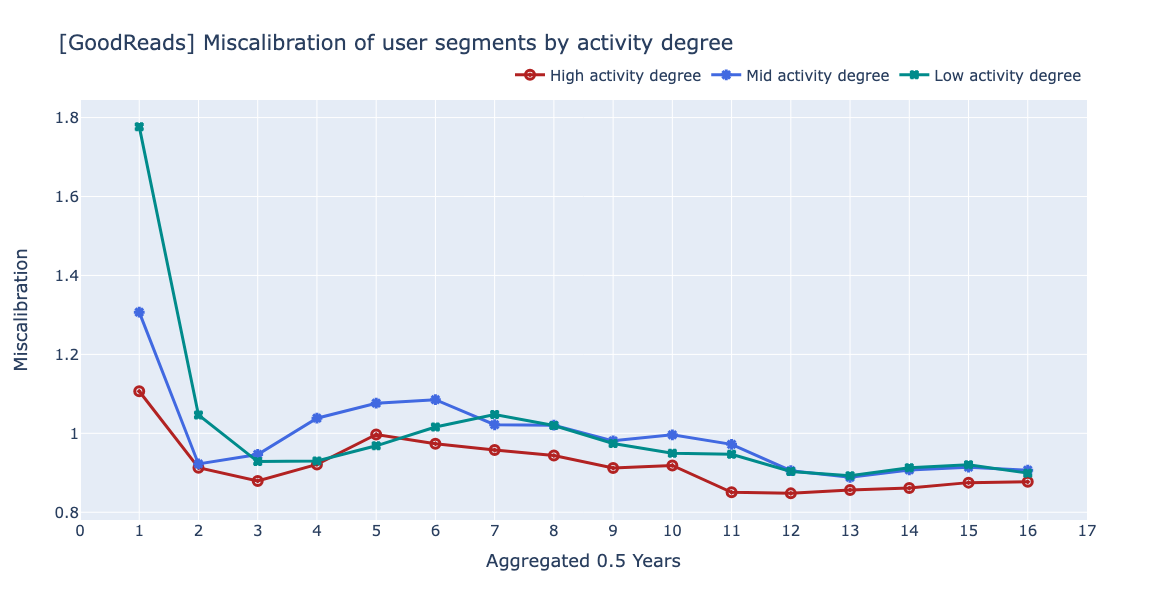

In [83]:
#lines = ['Low', 'Mid', 'High', 'All Population']
# segment users based on the count per user full history 
# viz 
DF = agg_across_1d_df
CAT_COL = 'DataIndex'
TARGET_COL = 'miscalibration'
DF_MEAN = DF[[CAT_COL,TARGET_COL]].groupby(CAT_COL, as_index=False).mean().melt(id_vars=CAT_COL)

GROUP_COL = 'user_group_activity'
DF_MEAN_GROUP = DF[[CAT_COL,TARGET_COL,GROUP_COL]].groupby([CAT_COL,GROUP_COL], as_index=False).mean().melt(id_vars=[CAT_COL,GROUP_COL])

lines_cat = 'activity degree'
lines = ['High', 'Mid', 'Low']
lines = [f"{_line} {lines_cat}" for _line in lines]
markers = ['circle-open-dot', 'asterisk-open', 'hash-open-dot']
colors = ['firebrick', 'royalblue', 'darkcyan']
dash = ['solid', 'dash', 'dot'] 

fig = go.Figure()
for i in range(3): 
    #df_mean_group = DF_MEAN_GROUP[DF_MEAN_GROUP[GROUP_COL]==i+1]
    df_mean_group = DF_MEAN_GROUP[DF_MEAN_GROUP[GROUP_COL]==3-i]
    fig.add_trace(go.Scatter(
        x=df_mean_group['DataIndex'], # x-axis
        y=df_mean_group['value'],  # y-axis
        mode='lines+markers', # Connect data points with lines and add markers
        name=lines[i], # Name in the legend

        marker=dict(
            symbol=markers[i],    # Change the marker symbol to a circle
            size=9,            # Set the marker size
            color=colors[i],
            line=dict(width=line_size)),       # Set the marker color

        line=dict(
            color=colors[i],        # Change the line color to red
            width=line_size)             # Set the line width
    ))


fig.update_layout(
    height=600, width=1300, 
    title='[GoodReads] Miscalibration of user segments by activity degree', # Title
    xaxis_title='Aggregated 0.5 Years', # y-axis name
    yaxis_title='Miscalibration', # x-axis name
    #xaxis_tickangle=45,  # Set the x-axis label angle
    showlegend=True,     # Display the legend
    xaxis = dict(
        tickmode = 'linear',
        dtick =dtick_length,
        range=[0,17]
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(
            size=legend_font_size,
        )),
    font=dict(size=font_size)
)

iplot(fig)
image_name = 'ActivityDegreeItemKNN'
fig.write_image(f"{image_path}{image_name_pref}_{image_name}.png")

### [c2] viz of user entropy 

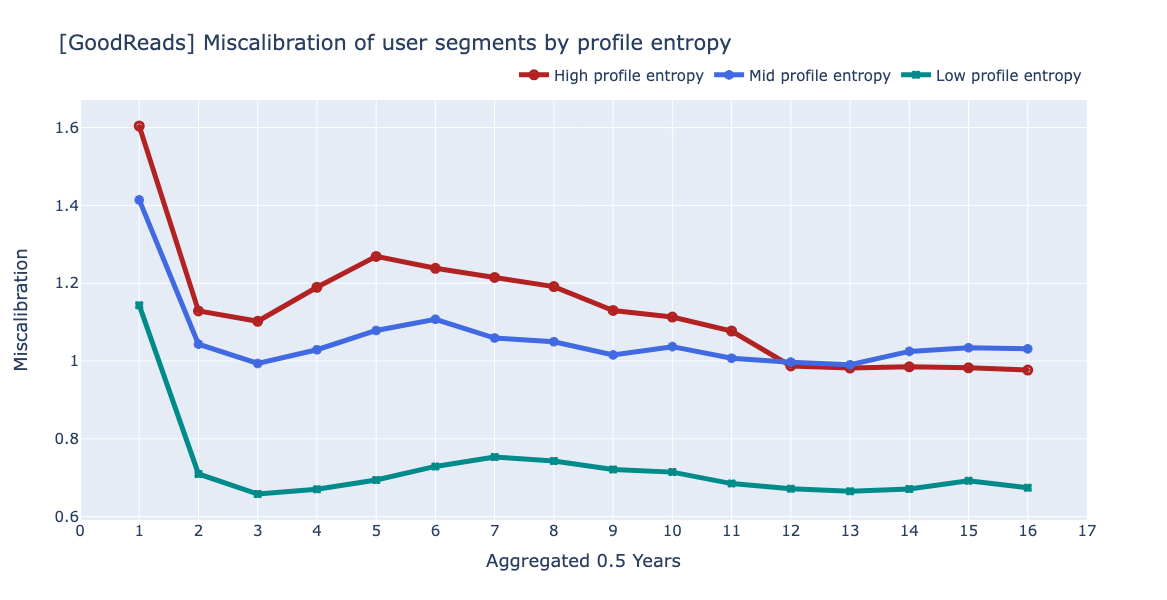

In [87]:
DF = agg_across_1d_df
CAT_COL = 'DataIndex'
TARGET_COL = 'miscalibration'
DF_MEAN = DF[[CAT_COL,TARGET_COL]].groupby(CAT_COL, as_index=False).mean().melt(id_vars=CAT_COL)

GROUP_COL = 'user_group_entropy'
DF_MEAN_GROUP = DF[[CAT_COL,TARGET_COL,GROUP_COL]].groupby([CAT_COL,GROUP_COL], as_index=False).mean().melt(id_vars=[CAT_COL,GROUP_COL])

lines_cat = 'profile entropy'
lines = ['High', 'Mid', 'Low']
lines = [f"{_line} {lines_cat}" for _line in lines]
markers = ['circle-open-dot', 'asterisk-open', 'hash-open-dot']
colors = ['firebrick', 'royalblue', 'darkcyan']
dash = ['solid', 'dash', 'dot'] 

fig = go.Figure()
for i in range(3): 
    #df_mean_group = DF_MEAN_GROUP[DF_MEAN_GROUP[GROUP_COL]==i+1]
    df_mean_group = DF_MEAN_GROUP[DF_MEAN_GROUP[GROUP_COL]==3-i]
    fig.add_trace(go.Scatter(
        x=df_mean_group['DataIndex'], # x-axis
        y=df_mean_group['value'], # y-axis
        mode='lines+markers', # Connect data points with lines and add markers
        name=lines[i], # Name in the legend

        marker=dict(
            symbol=markers[i],    # Change the marker symbol to a circle
            size=8,            # Set the marker size
            color=colors[i],
            line=dict(width=3)),       # Set the marker color

        line=dict(
            color=colors[i],        # Change the line color to red
            width=5)             # Set the line width
    ))

fig.update_layout(
    height=600, width=1300, 
    title='[GoodReads] Miscalibration of user segments by profile entropy', # Title
    xaxis_title='Aggregated 0.5 Years', # y-axis name
    yaxis_title=f'Miscalibration', # x-axis name
    #xaxis_tickangle=45,  # Set the x-axis label angle
    showlegend=True,     # Display the legend
    xaxis = dict(
        tickmode = 'linear',
        dtick =dtick_length,
        range=[0, 17]
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(
            size=legend_font_size,
        )),
    font=dict(size=font_size)
)

iplot(fig)
image_name = 'ProfileEntropyItemKNN'
fig.write_image(f"{image_path}{image_name_pref}_{image_name}.png")

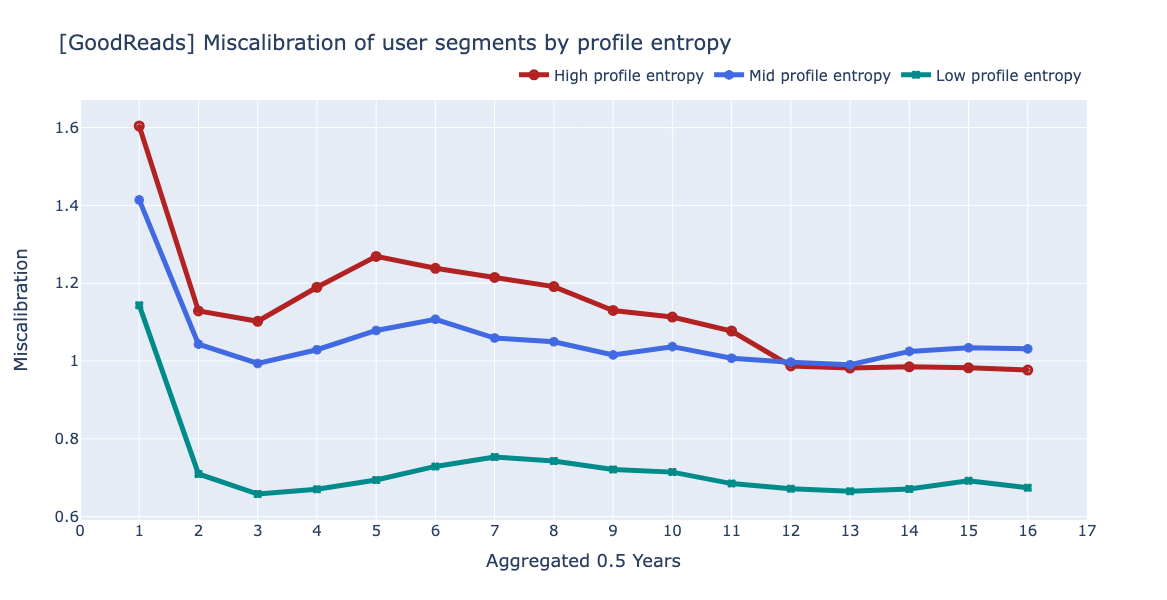

In [85]:
DF = agg_across_1d_df
CAT_COL = 'DataIndex'
TARGET_COL = 'miscalibration'
DF_MEAN = DF[[CAT_COL,TARGET_COL]].groupby(CAT_COL, as_index=False).mean().melt(id_vars=CAT_COL)

GROUP_COL = 'user_group_entropy'
DF_MEAN_GROUP = DF[[CAT_COL,TARGET_COL,GROUP_COL]].groupby([CAT_COL,GROUP_COL], as_index=False).mean().melt(id_vars=[CAT_COL,GROUP_COL])

lines_cat = 'profile entropy'
lines = ['High', 'Mid', 'Low']
lines = [f"{_line} {lines_cat}" for _line in lines]
markers = ['circle-open-dot', 'asterisk-open', 'hash-open-dot']
colors = ['firebrick', 'royalblue', 'darkcyan']
dash = ['solid', 'dash', 'dot'] 

fig = go.Figure()
for i in range(3): 
    #df_mean_group = DF_MEAN_GROUP[DF_MEAN_GROUP[GROUP_COL]==i+1]
    df_mean_group = DF_MEAN_GROUP[DF_MEAN_GROUP[GROUP_COL]==3-i]
    fig.add_trace(go.Scatter(
        x=df_mean_group['DataIndex'], # x-axis
        y=df_mean_group['value'], # y-axis
        mode='lines+markers', # Connect data points with lines and add markers
        name=lines[i], # Name in the legend

        marker=dict(
            symbol=markers[i],    # Change the marker symbol to a circle
            size=8,            # Set the marker size
            color=colors[i],
            line=dict(width=3)),       # Set the marker color

        line=dict(
            color=colors[i],        # Change the line color to red
            width=5)             # Set the line width
    ))

fig.update_layout(
    height=600, width=1300, 
    title='[GoodReads] Miscalibration of user segments by profile entropy', # Title
    xaxis_title='Aggregated 0.5 Years', # y-axis name
    yaxis_title=f'Miscalibration', # x-axis name
    #xaxis_tickangle=45,  # Set the x-axis label angle
    showlegend=True,     # Display the legend
    xaxis = dict(
        tickmode = 'linear',
        dtick =dtick_length,
        range=[0, 17]
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(
            size=legend_font_size,
        )),
    font=dict(size=font_size)
)

iplot(fig)
image_name = 'ProfileEntropyItemKNN'
fig.write_image(f"{image_path}{image_name_pref}_{image_name}.png")